# Churn prediction

In [150]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.class_weight import compute_sample_weight

# Output directory for graphs
output_directory = 'figures/'
if (not os.path.isdir(output_directory)):
    os.mkdir(output_directory)

## Data loading

In [57]:
df = pd.read_csv('Churn_Modelling.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## Data imbalance

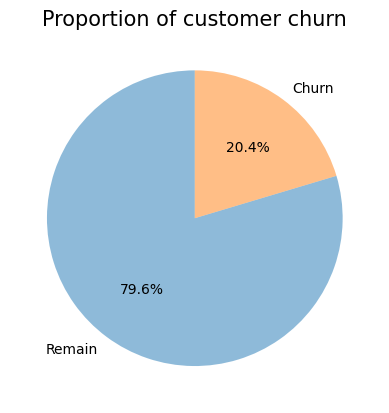

In [58]:
# Plot
plt.pie(df['Exited'].value_counts(),
        labels=['Remain', 'Churn'],
        wedgeprops={"alpha": 0.5},
        startangle=90,
        autopct='%1.1f%%')
plt.title('Proportion of customer churn', fontsize=15)
plt.savefig(os.path.join(output_directory, '2_1_churn_proportion.png'),
            bbox_inches='tight', dpi=600)
plt.show()

The dataset is imbalanced, with customer churn only representing a fifth of the data. This is to be expected for a functioning bank. This also means that we need to account for this imbalance to ensure models will not be biased. While we could do so using data over/under-sampling, we will here enforce balanced class weights during model training. 

## Data preparation

### Drop irrelevant columns

In [59]:
df_prep = df.copy()
df_prep = df_prep.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
df_prep

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


### Separate features and target

In [60]:
target_column = 'Exited'
feature_columns = df_prep.columns.to_list()
feature_columns.remove(target_column)

X = df_prep[feature_columns].copy()
y = df_prep[target_column].copy()

### Label and One-Hot encodings

In [61]:
# Label encode gender from Female/Male to 0/1
label_encoder = LabelEncoder()
X['Gender'] = label_encoder.fit_transform(X['Gender'])

# One-hot encode geography
X = pd.get_dummies(X, columns=['Geography'], drop_first=True)
X

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,False,True
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,39,5,0.00,2,1,0,96270.64,False,False
9996,516,1,35,10,57369.61,1,1,1,101699.77,False,False
9997,709,0,36,7,0.00,1,0,1,42085.58,False,False
9998,772,1,42,3,75075.31,2,1,0,92888.52,True,False


### Feature engineering

In [62]:
# Binary feature for balance
X['ZeroBalance'] = (X['Balance'] == 0)

# Age groups
# (One of these groups, 36-55, covers the majority of customers leaving the bank,
#  as seen during the exploratory data analysis)
X['AgeGroup'] = pd.cut(X['Age'],
                       bins=[18, 35, 55, 75, 95],
                       labels=['18-35', '36-55', '56-75', '76-95'])
X = pd.get_dummies(X, columns=['AgeGroup'], drop_first=True)

# Ratio of balance and salary
X['RatioBalanceSalary'] = X['Balance']/X['EstimatedSalary']

# Number of products used by active members (0 if inactive member)
X['ProductUsage'] = X['NumOfProducts']*X['IsActiveMember']

# Combined gender/geography features
X['Male_Germany'] = X['Gender']*X['Geography_Germany']
X['Male_Spain'] = X['Gender']*X['Geography_Spain']

X

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,ZeroBalance,AgeGroup_36-55,AgeGroup_56-75,AgeGroup_76-95,RatioBalanceSalary,ProductUsage,Male_Germany,Male_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,False,False,True,True,False,False,0.000000,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,False,True,False,True,False,False,0.744677,1,0,0
2,502,0,42,8,159660.80,3,1,0,113931.57,False,False,False,True,False,False,1.401375,0,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,False,False,True,True,False,False,0.000000,0,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,False,True,False,True,False,False,1.587055,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,39,5,0.00,2,1,0,96270.64,False,False,True,True,False,False,0.000000,0,0,0
9996,516,1,35,10,57369.61,1,1,1,101699.77,False,False,False,False,False,False,0.564108,1,0,0
9997,709,0,36,7,0.00,1,0,1,42085.58,False,False,True,True,False,False,0.000000,1,0,0
9998,772,1,42,3,75075.31,2,1,0,92888.52,True,False,False,True,False,False,0.808230,0,1,0


### Final type conversion

Making sure that boolean quantities are boolean in the data (to be automatically filtered out of the upcoming scaling).

In [69]:
# Convert relevant columns to bool
bool_columns = ['Gender', 'HasCrCard', 'IsActiveMember', 'Male_Germany', 'Male_Spain']
for c in bool_columns:
    X[c] = X[c].astype(bool)
 
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  int64  
 1   Gender              10000 non-null  bool   
 2   Age                 10000 non-null  int64  
 3   Tenure              10000 non-null  int64  
 4   Balance             10000 non-null  float64
 5   NumOfProducts       10000 non-null  int64  
 6   HasCrCard           10000 non-null  bool   
 7   IsActiveMember      10000 non-null  bool   
 8   EstimatedSalary     10000 non-null  float64
 9   Geography_Germany   10000 non-null  bool   
 10  Geography_Spain     10000 non-null  bool   
 11  ZeroBalance         10000 non-null  bool   
 12  AgeGroup_36-55      10000 non-null  bool   
 13  AgeGroup_56-75      10000 non-null  bool   
 14  AgeGroup_76-95      10000 non-null  bool   
 15  RatioBalanceSalary  10000 non-null  float64
 16  Produ

### Train/test split and feature scaling

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling (our features have very different scales)
# We do not scale boolean features
non_bool_features = X.select_dtypes(exclude=['bool']).columns

scaler = StandardScaler()
X_train[non_bool_features] = scaler.fit_transform(X_train[non_bool_features])
X_test[non_bool_features] = scaler.transform(X_test[non_bool_features])

## Model training, hyperparameter tuning and assessment

For churn prediction, one typically cares more about correctly predicting churn risks rather than correctly predicting all cases. Given customer churn is our positive class, we thus use the F1 score as a scoring metric when performing hyperparameter tuning _via_ cross-validated grid search. This tuning should strike a good balance between precision=TP/(TP+FP) and recall=TP/(TP+FN), maximizing true positives and minimizing false positives and false negatives. We will also make sure to train our models using class weights, to mitigate the effects of data imbalance. For bootstrap-based methods such as random forest, we will compute class weights at the bootstrap subsample level.

### Logistic regression

In [118]:
# Cross-validated grid search
param_grid = {
    'C': [0.1,0.5,1,10,50,100]
}

grid_search = GridSearchCV(
    estimator=LogisticRegression(class_weight='balanced',
                                 random_state=42),
    param_grid=param_grid,
    scoring='f1'
)
grid_search.fit(X_train, y_train)

# Best estimator
model_logreg = grid_search.best_estimator_
model_logreg

LogisticRegression(C=5, class_weight='balanced', random_state=42)

In [119]:
# Evaluation
y_pred = model_logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1607
           1       0.38      0.74      0.50       393

    accuracy                           0.71      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.81      0.71      0.74      2000



### Support vector machine (SVM)

#### Linear kernel

In [120]:
# Cross-validated grid search
param_grid = {
    'C': [0.1, 0.5, 1, 10, 50, 100]
}

grid_search = GridSearchCV(
    estimator=SVC(kernel='linear',
                  class_weight='balanced',
                  random_state=42),
    param_grid=param_grid,
    scoring='f1'
)
grid_search.fit(X_train, y_train)

# Best estimator
model_svm_linear = grid_search.best_estimator_
model_svm_linear

SVC(C=10, class_weight='balanced', kernel='linear', random_state=42)

In [121]:
# Evaluation
y_pred = model_svm_linear.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.70      0.79      1607
           1       0.38      0.74      0.50       393

    accuracy                           0.71      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.81      0.71      0.74      2000



#### Polynomial kernel

In [122]:
# Cross-validated grid search
param_grid = {
    'C': [0.1, 0.5, 1, 10, 50, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'degree': [2, 3]
}

grid_search = GridSearchCV(
    estimator=SVC(kernel='poly',
                  class_weight='balanced',
                  random_state=42),
    param_grid=param_grid,
    scoring='f1'
)
grid_search.fit(X_train, y_train)

# Best estimator
model_svm_poly = grid_search.best_estimator_
model_svm_poly

SVC(C=1, class_weight='balanced', gamma='auto', kernel='poly', random_state=42)

In [123]:
# Evaluation
y_pred = model_svm_poly.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.83      0.88      1607
           1       0.51      0.72      0.60       393

    accuracy                           0.81      2000
   macro avg       0.72      0.77      0.74      2000
weighted avg       0.84      0.81      0.82      2000



#### Radial kernel

In [124]:
# Cross-validated grid search
param_grid = {
    'C': [0.1, 0.5, 1, 10, 50, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(
    estimator=SVC(kernel='rbf',
                  class_weight='balanced',
                  random_state=42),
    param_grid=param_grid,
    scoring='f1'
)
grid_search.fit(X_train, y_train)

# Best estimator
model_svm_radial = grid_search.best_estimator_
model_svm_radial

SVC(C=100, class_weight='balanced', gamma=0.01, random_state=42)

In [125]:
# Evaluation
y_pred = model_svm_radial.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.79      0.86      1607
           1       0.47      0.76      0.58       393

    accuracy                           0.78      2000
   macro avg       0.70      0.77      0.72      2000
weighted avg       0.84      0.78      0.80      2000



### K-nearest neighbors

In [127]:
# Cross-validated grid search
param_grid = {
    'n_neighbors': [3, 4, 5, 6],
    'weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring='f1'
)
grid_search.fit(X_train, y_train)

# Best estimator
model_knn = grid_search.best_estimator_
model_knn

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [128]:
# Evaluation
y_pred = model_knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1607
           1       0.61      0.48      0.53       393

    accuracy                           0.84      2000
   macro avg       0.74      0.70      0.72      2000
weighted avg       0.83      0.84      0.83      2000



### Random forest

In [92]:
# Cross-validated grid search
param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [4, 6, 8],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                     random_state=42),
    param_grid=param_grid,
    scoring='f1'
)
grid_search.fit(X_train, y_train)

# Best estimator
model_rf = grid_search.best_estimator_
model_rf

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       min_samples_split=6, n_estimators=50, random_state=42)

In [146]:
# Evaluation
y_pred = model_rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1607
           1       0.58      0.69      0.63       393

    accuracy                           0.84      2000
   macro avg       0.75      0.78      0.76      2000
weighted avg       0.85      0.84      0.84      2000



### Gradient-boosting classifier

In [134]:
# Cross-validated grid search
param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [2, 3, 4, 5],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 3],
    'learning_rate': [0.05, 0.1, 1]
}

grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1'
)
grid_search.fit(X_train, y_train)

# Best estimator
model_gb = grid_search.best_estimator_
model_gb

GradientBoostingClassifier(max_depth=4, max_features='sqrt', random_state=42)

In [135]:
# Evaluation
y_pred = model_gb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1607
           1       0.75      0.50      0.60       393

    accuracy                           0.87      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



### Comparison

We use the receiver operating characteristic (ROC) curve and the precision recall curve to compare model performance. While the former returns the area under the curve (AUC), the latter returns the average precision (AP). Sample weights are used to account for data imbalance.

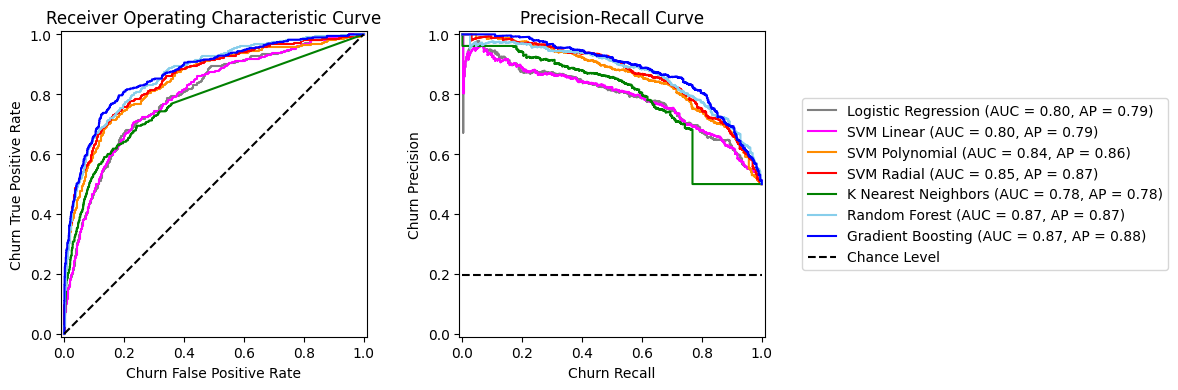

In [208]:
sample_weight = compute_sample_weight(class_weight="balanced", y=y_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
methods = ['Logistic Regression', 'SVM Linear', 'SVM Polynomial', 'SVM Radial',
           'K Nearest Neighbors', 'Random Forest', 'Gradient Boosting']

RocCurveDisplay.from_estimator(estimator=model_logreg, X=X_test, y=y_test,
                               sample_weight=sample_weight, ax=ax[0], color='grey')
RocCurveDisplay.from_estimator(estimator=model_svm_linear, X=X_test, y=y_test,
                               sample_weight=sample_weight, ax=ax[0], color='magenta')
RocCurveDisplay.from_estimator(estimator=model_svm_poly, X=X_test, y=y_test,
                               sample_weight=sample_weight, ax=ax[0], color='darkorange')
RocCurveDisplay.from_estimator(estimator=model_svm_radial, X=X_test, y=y_test,
                               sample_weight=sample_weight, ax=ax[0], color='red')
RocCurveDisplay.from_estimator(estimator=model_knn, X=X_test, y=y_test,
                               sample_weight=sample_weight, ax=ax[0], color='green')
RocCurveDisplay.from_estimator(estimator=model_rf, X=X_test, y=y_test,
                               sample_weight=sample_weight, ax=ax[0], color='skyblue')
RocCurveDisplay.from_estimator(estimator=model_gb, X=X_test, y=y_test,
                               sample_weight=sample_weight, ax=ax[0], color='blue', plot_chance_level=True)

# Read AUC values
AUC_values = []
h, l = ax[0].get_legend_handles_labels()
for i in range(len(methods)):
    l[i] = methods[i] + ' (' + l[i].split('(')[1]
    AUC_values.append(l[i].split('(')[1].split(')')[0])
ax[0].legend().remove()

ax[0].set_title('Receiver Operating Characteristic Curve')
ax[0].set_ylabel('Churn True Positive Rate')
ax[0].set_xlabel('Churn False Positive Rate')

PrecisionRecallDisplay.from_estimator(estimator=model_logreg, X=X_test, y=y_test,
                                      sample_weight=sample_weight, ax=ax[1], color='grey')
PrecisionRecallDisplay.from_estimator(estimator=model_svm_linear, X=X_test, y=y_test,
                                      sample_weight=sample_weight, ax=ax[1], color='magenta')
PrecisionRecallDisplay.from_estimator(estimator=model_svm_poly, X=X_test, y=y_test,
                                      sample_weight=sample_weight, ax=ax[1], color='darkorange')
PrecisionRecallDisplay.from_estimator(estimator=model_svm_radial, X=X_test, y=y_test,
                                      sample_weight=sample_weight, ax=ax[1], color='red')
PrecisionRecallDisplay.from_estimator(estimator=model_knn, X=X_test, y=y_test,
                                      sample_weight=sample_weight, ax=ax[1], color='green')
PrecisionRecallDisplay.from_estimator(estimator=model_rf, X=X_test, y=y_test,
                                      sample_weight=sample_weight, ax=ax[1], color='skyblue')
PrecisionRecallDisplay.from_estimator(estimator=model_gb, X=X_test, y=y_test,
                                      sample_weight=sample_weight, ax=ax[1], color='blue', plot_chance_level=True)

h, l = ax[1].get_legend_handles_labels()
for i in range(len(methods)):
    l[i] = methods[i] + ' (' + AUC_values[i] + ', ' + l[i].split('(')[1]
l[-1] = 'Chance Level'
ax[1].legend(h, l, loc='center left', bbox_to_anchor=(1.1, 0.5))

ax[1].set_title('Precision-Recall Curve')
ax[1].set_ylabel('Churn Precision')
ax[1].set_xlabel('Churn Recall')

plt.tight_layout(w_pad=2.5)
plt.savefig(os.path.join(output_directory, '2_2_ROC_PR_curves.png'),
            bbox_inches='tight', dpi=600)
plt.show()

**Breakdown:**
- The logistic-regression, linear-kernel support-vector-machine and k-nearest-neighbor classifiers performed rather poorly compared to other models.
- The polynomial-kernel and radial-kernel support vector machines performed well, but were surpassed by the random-forest and gradient-boosting classifiers. 
- Even though the random-forest and gradient-boosting classifiers performed similarly, they yielded different levels of precision and recall (for similar F1 scores) when predicting churn (see above classification reports for positive label 1).
    - Random forest model: precision=0.58 and recall=0.69 for predicting churn.
    - Gradient-boosting model: precision=0.75 and recall=0.50 for predicting churn.
- When predicting churn, one typically cares more about avoiding false negatives (which may prove costly to the bank) rather than false positives, thereby favoring maximizing recall=TP/(TP+FN) over precision=TP/(TP+FP).
    - In that sense, the random-forest classifier performs better than the gradient-boosting model.

### Feature importance

Let us plot feature importances for our two best classifiers.

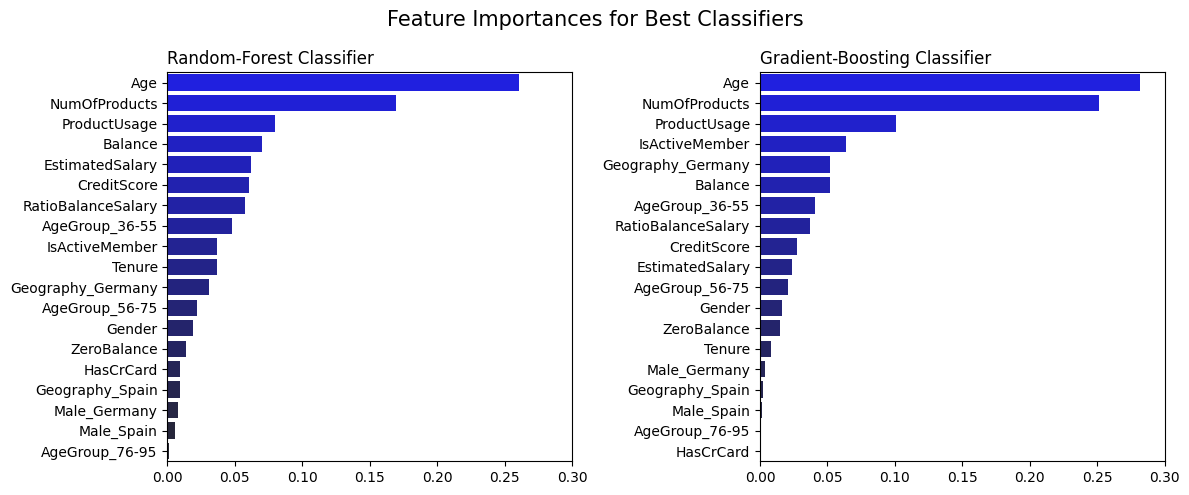

In [201]:
models = {'Random-Forest Classifier': model_rf,
          'Gradient-Boosting Classifier': model_gb}

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i, (model_name, model) in enumerate(models.items()):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    names = [X.columns[i] for i in indices]

    sns.barplot(x=importances[indices], y=range(X.shape[1]), hue=range(X.shape[1]),
                ax=ax[i], orient='h', palette='dark:b_r', legend=False)
    ax[i].set_yticks(range(X.shape[1]), names)
    ax[i].set_title(model_name, loc='left')
    ax[i].set_xlim([0, 0.3])
plt.suptitle('Feature Importances for Best Classifiers',
             y=0.98, fontsize=15)
plt.tight_layout(h_pad=1.5)
plt.savefig(os.path.join(output_directory, '2_3_feature_importance_best_classifiers.png'),
            bbox_inches='tight', dpi=600)
plt.show()

**Breakdown:**
- The three most important features to predict churn (also common to both the random-forest and gradient-boosting classifiers) are:
    - the customer age `Age`.
    - the number of products used by the customer `NumOfProducts`.
    - the newly engineered effective product usage `ProductUsage`, _i.e._, the number of products used by active bank members (inactive bank members are considered to have zero product usage).
- The following features are rather unimportant for both classifiers: `HasCrCard`, `Geography_Spain`, `Male_Spain`, `Male_Germany`, `AgeGroup_56-75`, `AgeGroup_76-95`, `ZeroBalance`, `Gender`.
- While the exploratory data analysis identified customer age, gender account balance and geographical location (mostly Germany) as promising features for predicting churn, gender is not very important for classification in the end.

## Feature selection

Let us remove the 8 aforementioned unimportant features and see how the classifiers perform.

In [232]:
features_to_remove = ['HasCrCard', 'Geography_Spain', 'Male_Spain',
                      'Male_Germany', 'AgeGroup_56-75', 'AgeGroup_76-95',
                      'ZeroBalance', 'Gender']
new_feature_set = [x for x in X.columns if x not in features_to_remove]

X_train_2 = X_train[new_feature_set].copy()
X_test_2 = X_test[new_feature_set].copy()

In [237]:
# Cross-validated grid search
param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [6, 8, 10],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                     random_state=42),
    param_grid=param_grid,
    scoring='f1'
)
grid_search.fit(X_train_2, y_train)

# Best estimator
model_rf_2 = grid_search.best_estimator_
model_rf_2

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       min_samples_split=8, n_estimators=50, random_state=42)

In [238]:
# Evaluation
y_pred = model_rf_2.predict(X_test_2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1607
           1       0.58      0.67      0.62       393

    accuracy                           0.84      2000
   macro avg       0.75      0.78      0.76      2000
weighted avg       0.85      0.84      0.84      2000



In [245]:
# Cross-validated grid search
param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [5, 6, 7],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1'
)
grid_search.fit(X_train_2, y_train)

# Best estimator
model_gb_2 = grid_search.best_estimator_
model_gb_2

GradientBoostingClassifier(learning_rate=0.05, max_depth=6, max_features='sqrt',
                           random_state=42)

In [246]:
# Evaluation
y_pred = model_gb_2.predict(X_test_2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.48      0.58       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.87      0.85      2000



Both classifiers still perform similarly to above after going down from 19 to 11 features.